# COMP4318/5318 Assignment 2: Image Classification

### Group number: A2 Group46  , SID1: 540237849 , SID2: 540349681, SID3: 530698180

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import time

# Import our deep learning libraries 
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

# Make the notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)
keras.backend.clear_session()

# Set up inline plotting and figure/axis labels
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


"""Plot a grid of images which are encoded as numpy arrays"""    
def plot_examples(data, n_rows=4, n_cols=10):
    
    # Remove redundant extra dimension
    if data.shape[-1] == 1:
        data = data.squeeze(axis=-1)
    
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    
    for row in range(n_rows):
        for col in range(n_cols):
            # Get next index of image
            index = n_cols * row + col
            
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")  # Change colormap here
            plt.axis('off')
    
    plt.show()

## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [2]:
# Load the dataset training and test sets as numpy arrays
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

### Examples of preprocessed data


The Pixel values ranges from 0 to 255, so we first normalize our data by deviding each pixel values by 255 \
so that they can be scaled to between 0 and 1. Then we flat the train and test into two dimension array \
and convert it into a pandas dataframe where each of 784 pixels is a column attributes. This practice \
mainly allows us to make function to plot sample imagines and create a bar chart to display the frequency \
of each class labels in train and test sets. Additionally, we also define a function to help us check the \
pixel intensity statistics. These steps can help us better understand our data.  

In [3]:
#Normalize Pixels
X_train = X_train/255
X_test = X_test/255

In [4]:
### Defining function showing pixel intensity statistics of given array image.
### Statistics are Min, Max, Mean and Standard deviations

def check_pixel_intensity(images):

    # Iterate through each image in the array
    for i, img in enumerate(images):
        # Calculate statistics
        min_intensity = np.min(img)
        max_intensity = np.max(img)
        mean_intensity = np.mean(img)
        std_dev_intensity = np.std(img)
        
        # Print the statistics for the image
        print(f"Image {i + 1}: Min={min_intensity}, Max={max_intensity}, Mean={mean_intensity:.2f}, Std Dev={std_dev_intensity:.2f}")

# Example usage:
X_train_subset = X_train[:10]  # Select the first 10 images
check_pixel_intensity(X_train_subset)

Image 1: Min=0.0, Max=1.0, Mean=0.43, Std Dev=0.32
Image 2: Min=0.0, Max=1.0, Mean=0.31, Std Dev=0.29
Image 3: Min=0.0, Max=1.0, Mean=0.48, Std Dev=0.25
Image 4: Min=0.0, Max=0.984313725490196, Mean=0.46, Std Dev=0.38
Image 5: Min=0.39215686274509803, Max=1.0, Mean=0.94, Std Dev=0.15
Image 6: Min=0.12549019607843137, Max=1.0, Mean=0.67, Std Dev=0.20
Image 7: Min=0.0, Max=1.0, Mean=0.49, Std Dev=0.28
Image 8: Min=0.0, Max=0.9607843137254902, Mean=0.53, Std Dev=0.17
Image 9: Min=0.0, Max=1.0, Mean=0.33, Std Dev=0.33
Image 10: Min=0.1411764705882353, Max=1.0, Mean=0.61, Std Dev=0.25


In [5]:
# Flatten the training and testing images
X_train_flatten = X_train.reshape((X_train.shape[0], -1))  # Reshape from (num_samples, 28, 28) to (num_samples, 784)
X_test_flatten = X_test.reshape((X_test.shape[0], -1))  # Reshape from (num_samples, 28, 28) to (num_samples, 784)

###Create pandas dataframe where column attributes are 28*28 pixel values
df_train = pd.DataFrame(X_train_flatten, columns=[f'pixel_{i}' for i in range(X_train_flatten.shape[1])])
df_test = pd.DataFrame(X_test_flatten, columns=[f'pixel_{i}' for i in range(X_test_flatten.shape[1])])

df_train['label'] = y_train  # Add the training labels
df_test['label'] = y_test

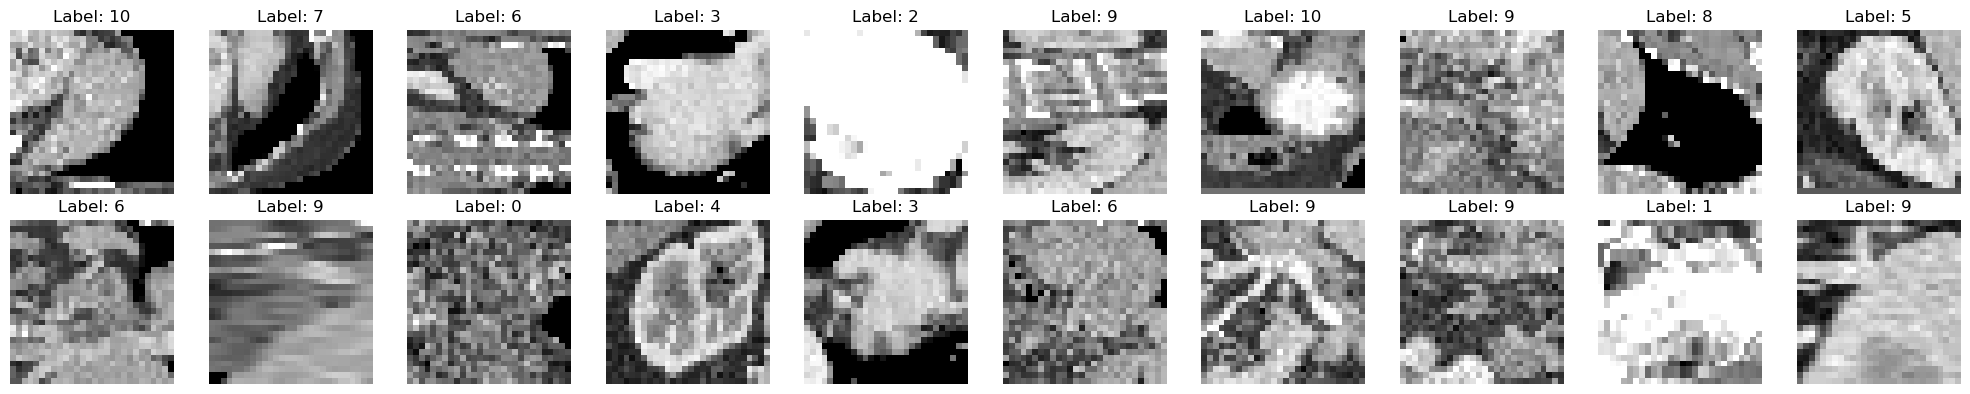

In [6]:
### Defining a function showing the sample imagines and corresponding labels in a specified rows and columns. 

def plot_examples(X_train, y_train, rows, cols):
    if len(X_train) < rows * cols:
        raise ValueError("Not enough images/labels to display") #error if wrong size
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()
    for i in range(rows * cols):
        axes[i].imshow(X_train[i], cmap='gray') 
        axes[i].set_title(f"Label: {y_train[i]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_examples(X_train, y_train, 2, 10)


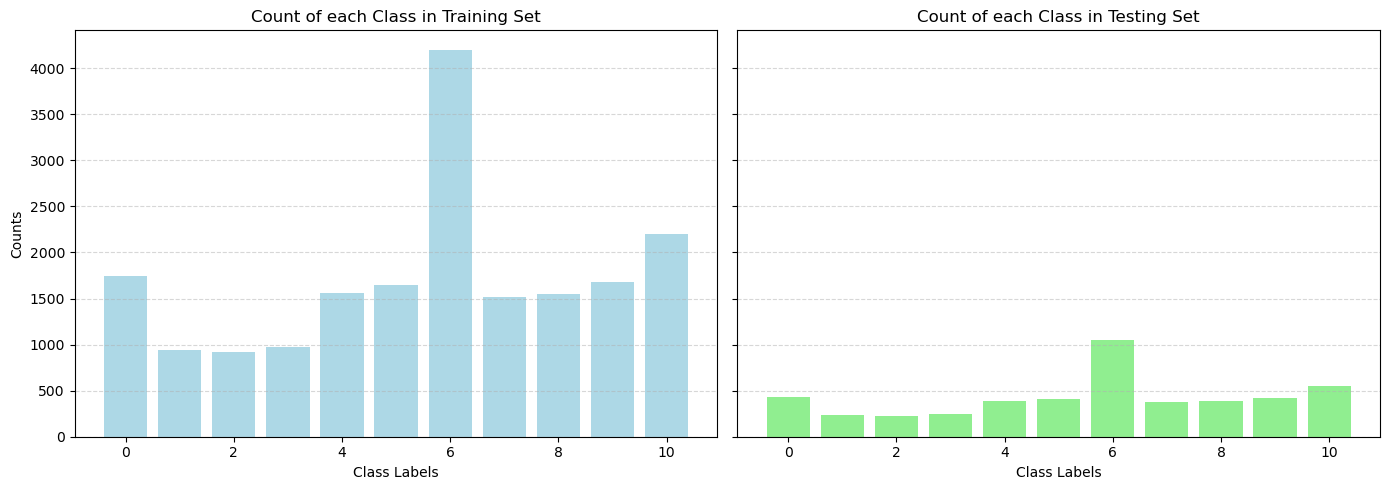

In [7]:
### Create bar charts which display the counts of class label in train and test sets.

train_class_counts = df_train.iloc[:, -1].value_counts().sort_index()
test_class_counts = df_test.iloc[:, -1].value_counts().sort_index()
# Plotting class distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot training data class distribution
ax[0].bar(train_class_counts.index, train_class_counts.values, color='lightblue', alpha=1)
ax[0].set_title('Count of each Class in Training Set')
ax[0].set_xlabel('Class Labels')
ax[0].set_ylabel('Counts')
ax[0].grid(axis='y', linestyle='--', alpha=0.5)

# Plot testing data class distribution
ax[1].bar(test_class_counts.index, test_class_counts.values, color='lightgreen', alpha=1)
ax[1].set_title('Count of each Class in Testing Set')
ax[1].set_xlabel('Class Labels')
ax[1].grid(axis='y', linestyle='--', alpha=0.5)

# Adjust layout and display the plot
plt.tight_layout()

## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

We first attemptted three classification algorith from first six weeks, including Random Forest, Naive Bayes, and KNN. \
The Random Forest has the best accuracy at 90% at the test set without tuning the hyperparameters. Thus, we decided to \
utilize random forest model in later parts.

In [8]:
np.random.seed(5318)
### Random Forest 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_flatten, y_train)
y_pred = rf_classifier.predict(X_test_flatten) 
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy: 2f}")

### Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_flatten, y_train)
y_pred = nb_classifier.predict(X_test_flatten)
accuracy = accuracy_score(y_test, y_pred)
print(f"Naive Bayes Accuracy: {accuracy: 2f}")

### KNN classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_flatten, y_train)
y_pred = knn_classifier.predict(X_test_flatten)
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {accuracy: 2f}")

Random Forest Accuracy:  0.903212
Naive Bayes Accuracy:  0.684277
KNN Accuracy:  0.794801


### Fully connected neural network

We define a function for MLP model with two hidden layers and Relu activation function and output being transformed \
by softmax function. We used adam optimier and sparse categorical crossentropy for loss function with accuracy as metrics. \
The hyperparameter chosen at this stage is just randomly chosen. 

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score

np.random.seed(5318)
num_classes = 11

from sklearn.model_selection import train_test_split
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, train_size=0.9, random_state=5318)

def mlp(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256, activation='relu')) #first hidden layer 256 neurons
    model.add(Dense(64, activation='relu')) # second hidden layer 64 nrurons
    model.add(Dense(num_classes, activation='softmax'))  # Adjusted to the number of classes
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

fcnn= mlp(X_train1.shape[1:])


fcnn.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val,y_val))

Epoch 1/10


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5180 - loss: 1.4313 - val_accuracy: 0.7242 - val_loss: 0.8518
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7323 - loss: 0.8392 - val_accuracy: 0.7528 - val_loss: 0.7571
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7689 - loss: 0.7263 - val_accuracy: 0.7813 - val_loss: 0.6548
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7926 - loss: 0.6445 - val_accuracy: 0.8098 - val_loss: 0.5805
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8117 - loss: 0.5805 - val_accuracy: 0.8199 - val_loss: 0.5285
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8297 - loss: 0.5252 - val_accuracy: 0.8315 - val_loss: 0.4950
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8408 - loss: 0.4813 - val_accuracy: 0.8415 - val_loss: 0.4585
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8548 - loss: 0.4436 - val_accuracy: 0.8590 - val_

### Convolutional neural network

For the convolutional neural network, there are three convolutional layers are being added \
and each convolutional layer applies a number of different filters with 3 times 3 pixels. \
Each layer followed by max pooling layer by 2 times 2 pixels. The pooling output will be input for the mlp input. 

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

np.random.seed(5318)
def cnn(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape)) #32 different filters 
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu')) # 64 filters
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu')) # 128 filters
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))  
    model.add(Dense(num_classes, activation='softmax'))  

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Reshape input data 
X_train_reshaped = X_train.reshape(-1, 28, 28, 1)
X_val_reshaped = X_val.reshape(-1, 28, 28, 1)

cnn1 = cnn(X_train_reshaped.shape[1:], 11)

cnn1.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_val_reshaped, y_val))

Epoch 1/10


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


592/592 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4320 - loss: 1.6507 - val_accuracy: 0.6947 - val_loss: 0.8821
Epoch 2/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7322 - loss: 0.8093 - val_accuracy: 0.7739 - val_loss: 0.6190
Epoch 3/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7952 - loss: 0.6187 - val_accuracy: 0.8389 - val_loss: 0.4873
Epoch 4/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8296 - loss: 0.5117 - val_accuracy: 0.8579 - val_loss: 0.4332
Epoch 5/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8542 - loss: 0.4346 - val_accuracy: 0.8669 - val_loss: 0.3770
Epoch 6/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8699 - loss: 0.3876 - val_accuracy: 0.8848 - val_loss: 0.3468
Epoch 7/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8844 - loss: 0.3374 - val_accuracy: 0.8875 - val_loss: 0.3293
Epoch 8/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8951 - loss: 0.3019 - val_accuracy: 0.9007 - val_

## 3. Hyperparameter tuning

In this section, we tune hyparameters for each of the tree model using gridsearch and cross validation

### 3.1 Algorithm of choice from first six weeks of course

In [11]:
### Grid search Random Forest
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
parameters = {'n_estimators': [50, 100],
              'max_depth': [None, 10, 20],
             'min_samples_split':[2,10,20]}
clf4 = GridSearchCV(RandomForestClassifier(), parameters)
clf4.fit(X_train.reshape(X_train.shape[0], -1), y_train)

print("Best parameters for Random Forest:", clf4.best_params_)

Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


### 3.2 Fully Connected Neural Network

In [16]:
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.base import BaseEstimator

## Define a custom Keras classifier inheriting from KerasClassifier and BaseEstimator
class CustomKerasClassifier(KerasClassifier, BaseEstimator):
    def __init__(self, neurons1=128, neurons2=64, **kwargs):
        self.neurons1 = neurons1
        self.neurons2 = neurons2
        super().__init__(**kwargs)

## build the Keras model
    def _keras_build_fn(self, **kwargs):
        model = Sequential()
        model.add(Flatten(input_shape=X_train.shape[1:]))
        model.add(Dense(self.neurons1, activation='relu'))
        model.add(Dense(self.neurons2, activation='relu'))
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

optimizers = [Adam(), SGD()]

fcnn = CustomKerasClassifier(neurons1=128, neurons2=64, epochs=10, batch_size=64)

## Define Hyparameter grid
params_nn ={
 
    'optimizer': optimizers, 
    'batch_size': [200, 500],
    'epochs': [20, 50]
}

clf = GridSearchCV(fcnn, params_nn, cv=3, verbose=2, n_jobs=-1)
clf.fit(X_train, y_train)

print("Best parameters for FNN:", clf.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/ansonpoon/Desktop/anaconda3/lib/pyth

Epoch 1/20
Epoch 1/20
Epoch 1/50
Epoch 1/20
Epoch 1/50
Epoch 1/20
Epoch 1/50
Epoch 1/50
Epoch 1/20
Epoch 1/50
Epoch 1/20
Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3891 - loss: 1.82762
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3733 - loss: 1.8692
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3919 - loss: 1.8140
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3726 - loss: 1.8912
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4113 - loss: 1.8103
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4126 - loss: 1.7519
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4079 - loss: 1.7642
 1/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5600 - loss: 1.1325Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3647 - loss: 1.8836
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3779 - loss: 1.8618
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8637 - loss: 0.4283
Epoch 21/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8695 - loss: 0.3979
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8592 - loss: 0.4260
Epoch 22/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8656 - loss: 0.4117
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8623 - loss: 0.4205 
Epoch 22/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8523 - loss: 0.450
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8393 - loss: 0.4862 
47/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8371 - loss: 0.5120[CV] END batch_size=200, epochs=20, optimizer=<keras.src.optimizers.adam.Adam object at 0x14ddd2fd0>; total time=   8.2s
34/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8375 - loss: 0.4926 [CV] END batch_size=200, epochs=20, optimizer=<keras.src.optimizers.sgd.SGD object at 0x2a612e350>; total time=   8.2s
40/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8364 - loss: 0

/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8684 - loss: 0.41
 1/64 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8500 - loss: 0.4982[CV] END batch_size=200, epochs=20, optimizer=<keras.src.optimizers.adam.Adam object at 0x2a2a93ed0>; total time=   8.5s
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3109 - loss: 2.0484  
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8675 - loss: 0.4200
Epoch 23/50
39/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8708 - loss: 0.4072Epoch 1/20
15/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5987 - loss: 1.2664 

/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8731 - loss: 0.4017
Epoch 23/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/stepp - accuracy: 0.8432 - loss: 0.4804
[CV] END batch_size=200, epochs=20, optimizer=<keras.src.optimizers.adam.Adam object at 0x2a47bdb10>; total time=   8.8s
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6099 - loss: 1.2325 
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2917 - loss: 2.0847
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2800 - loss: 2.1313
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6500 - loss: 1.1081Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8729 - loss: 0.3936
Epoch 24/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8770 - loss: 0.39431
Epoch 23/50
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8408 - loss: 0.4887Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5995 - loss: 1.2746
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.58

/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2937 - loss: 2.0984
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8643 - loss: 0.4262
Epoch 2/20
Epoch 24/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8552 - loss: 0.4407
12/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8248 - loss: 0.5021Epoch 21/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5869 - loss: 1.2802
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8421 - loss: 0.4891
Epoch 17/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6647 - loss: 1.0382  
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8682 - loss: 0.4005
Epoch 24/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8742 - loss: 0.3914
Epoch 25/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6737 - loss: 1.0389
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6989 - loss: 0.9368
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8792 - loss: 0.38576
Epo

/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8644 - loss: 0.4198
21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7975 - loss: 0.6456Epoch 21/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7762 - loss: 0.6898
53/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9048 - loss: 0.3018Epoch 13/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7991 - loss: 0.6408
Epoch 16/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7932 - loss: 0.6512
Epoch 13/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9044 - loss: 0.3028
Epoch 32/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9002 - loss: 0.3130
Epoch 31/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7976 - loss: 0.6312
Epoch 16/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8043 - loss: 0.6017
Epoch 16/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8764 - loss: 0.3728
Epoch 26/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7959 - loss: 0.6478
13/26 ━━━━━━━━━━━

/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9023 - loss: 0.3034
Epoch 36/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9171 - loss: 0.2542
Epoch 35/50
Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9033 - loss: 0.2940
Epoch 35/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8263 - loss: 0.5456
Epoch 20/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8700 - loss: 0.4013
Epoch 24/50
16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7650 - loss: 0.7754Epoch 1/50
Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7630 - loss: 0.7739 
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8253 - loss: 0.5472
Epoch 18/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8899 - loss: 0.3447
Epoch 29/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9223 - loss: 0.2518
Epoch 36/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9151 - loss: 0.27485
Epoch 37/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - ac

/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7212 - loss: 0.9046
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7904 - loss: 0.6639
Epoch 13/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7320 - loss: 0.8547
Epoch 6/50
44/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9174 - loss: 0.2536Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7351 - loss: 0.8474[CV] END batch_size=500, epochs=20, optimizer=<keras.src.optimizers.sgd.SGD object at 0x2a2ad28d0>; total time=   6.1s
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7351 - loss: 0.8473
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 0.3328
Epoch 31/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9187 - loss: 0.2499
Epoch 39/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9217 - loss: 0.2546
Epoch 40/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7347 - loss: 0.8450
Epoch 7/50
26/26 ━━━━

/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7463 - loss: 0.8104
38/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8980 - loss: 0.3179Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8907 - loss: 0.3332
Epoch 27/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7564 - loss: 0.7707 
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9135 - loss: 0.2667
Epoch 41/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9223 - loss: 0.2429
Epoch 40/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7931 - loss: 0.6426
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9166 - loss: 0.2632Epoch 15/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9168 - loss: 0.2624
Epoch 40/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7598 - loss: 0.7736
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8979 - loss: 0.3165
Epoch 32/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7593 - loss: 0.7688
Epoch 9/50
26/26 ━━━

/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9273 - loss: 0.2200
Epoch 41/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7236 - loss: 0.8903
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8947 - loss: 0.3149
Epoch 31/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9294 - loss: 0.2183
Epoch 45/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9314 - loss: 0.2147
Epoch 46/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8225 - loss: 0.5602
Epoch 17/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7280 - loss: 0.8735
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8149 - loss: 0.58343
 7/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8922 - loss: 0.3214 Epoch 16/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9123 - loss: 0.2726
Epoch 36/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9307 - loss: 0.20586
Epoch 46/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7296 - loss: 0.8619 
Epo

/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4723 - loss: 1.6108
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7058 - loss: 0.9289
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7401 - loss: 0.8245
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7558 - loss: 0.7650
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7687 - loss: 0.7153
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7845 - loss: 0.6724
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7988 - loss: 0.6317
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8053 - loss: 0.6067
Epoch 9/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8169 - loss: 0.5716
Epoch 10/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8235 - loss: 0.5473
Epoch 11/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8313 - loss: 0.5200
Epoch 12/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8406 - loss: 0.4935


### 3.3 Convolutional neural network

In [14]:
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import GridSearchCV

### Set up CNN model and set learning rate as 0.001
def cnn_model(optimizer='adam', learning_rate=0.001):
    """Create a convolutional neural network model."""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(11, activation='softmax')  # 11 classes for the output layer
    ])

    if optimizer == 'adam':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    elif optimizer == 'rmsprop':
        model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    else:
        model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

## define grid search funciton
def perform_cnn_grid_search(X_train, y_train):
    """Perform grid search on the CNN model."""
    cnn = KerasClassifier(model=cnn_model, epochs=10, batch_size=32, verbose=0)

    parameters ={
        'optimizer': ['adam', 'sgd'],
        'batch_size': [200, 500],
        'epochs': [20, 50]
    }

    grid_search = GridSearchCV(cnn, parameters, cv=3, verbose=2)
    grid_search.fit(X_train, y_train)

    return grid_search.best_params_

best_cnn_params = perform_cnn_grid_search(X_train, y_train)
print("Best parameters for CNN:", best_cnn_params)



Fitting 3 folds for each of 8 candidates, totalling 24 fits


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ..........batch_size=200, epochs=20, optimizer=adam; total time=  24.5s


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ..........batch_size=200, epochs=20, optimizer=adam; total time=  24.4s


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ..........batch_size=200, epochs=20, optimizer=adam; total time=  24.2s


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ...........batch_size=200, epochs=20, optimizer=sgd; total time=  24.1s


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ...........batch_size=200, epochs=20, optimizer=sgd; total time=  24.8s


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ...........batch_size=200, epochs=20, optimizer=sgd; total time=  24.8s


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ..........batch_size=200, epochs=50, optimizer=adam; total time= 1.0min


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ..........batch_size=200, epochs=50, optimizer=adam; total time= 1.0min


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ..........batch_size=200, epochs=50, optimizer=adam; total time= 1.0min


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ...........batch_size=200, epochs=50, optimizer=sgd; total time=  59.9s


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ...........batch_size=200, epochs=50, optimizer=sgd; total time= 1.0min


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ...........batch_size=200, epochs=50, optimizer=sgd; total time= 1.0min


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ..........batch_size=500, epochs=20, optimizer=adam; total time=  20.8s


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ..........batch_size=500, epochs=20, optimizer=adam; total time=  20.6s


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ..........batch_size=500, epochs=20, optimizer=adam; total time=  20.7s


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ...........batch_size=500, epochs=20, optimizer=sgd; total time=  20.7s


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ...........batch_size=500, epochs=20, optimizer=sgd; total time=  21.7s


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ...........batch_size=500, epochs=20, optimizer=sgd; total time=  21.3s


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ..........batch_size=500, epochs=50, optimizer=adam; total time=  51.3s


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ..........batch_size=500, epochs=50, optimizer=adam; total time=  51.1s


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ..........batch_size=500, epochs=50, optimizer=adam; total time=  50.6s


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ...........batch_size=500, epochs=50, optimizer=sgd; total time=  50.5s


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ...........batch_size=500, epochs=50, optimizer=sgd; total time=  50.8s


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[CV] END ...........batch_size=500, epochs=50, optimizer=sgd; total time=  49.9s


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Best parameters for CNN: {'batch_size': 200, 'epochs': 50, 'optimizer': 'sgd'}


## 4. Final models
In this section, we fit the three models indenpendently using best hyperparameter sets derived from the gridsearch and cross validation. \
We also calculate the clasification accuracy rate for each model in test set. 

### Algorithm of choice from first six weeks of course

In [17]:
### random forest parameters set from grid search
np.random.state = 5318
clf4_best = RandomForestClassifier(n_estimators=50, 
                                   max_depth=20, min_samples_split=2)
clf4_best.fit(X_train.reshape(X_train.shape[0], -1), y_train)
predictions4 = clf4_best.predict(X_test.reshape(X_test.shape[0], -1))
accuracy4 = accuracy_score(y_test, predictions4)
print(f"Accuracy of Random Forest: {accuracy4 * 100:.2f}%")

Accuracy of Random Forest: 89.22%


### Fully connected neural network

In [35]:
### CNN with best parameters set selected by grid search
def mlp_model(): 
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))  # Assumption about input shape
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

np.random.seed(5318)
# Create a new model instance using the best optimizer found
model = mlp_model()

# Fit the model on the entire training dataset
history=model.fit(X_train, y_train, epochs=50, batch_size=200, validation_data=(X_val_reshaped, y_val))

# Assuming X_test and y_test are available and preprocessed in the same way as X_train
predictions = model.predict(X_test)

# Since predictions will be probabilities, we convert them to class labels
predicted_classes_mlp = np.argmax(predictions, axis=1)


Epoch 1/50


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3792 - loss: 1.8552 - val_accuracy: 0.6529 - val_loss: 1.1311
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6058 - loss: 1.1594 - val_accuracy: 0.6017 - val_loss: 1.1011
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6760 - loss: 0.9783 - val_accuracy: 0.7359 - val_loss: 0.8335
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7120 - loss: 0.8674 - val_accuracy: 0.7718 - val_loss: 0.7168
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7411 - loss: 0.7688 - val_accuracy: 0.7781 - val_loss: 0.6606
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7618 - loss: 0.7064 - val_accuracy: 0.8019 - val_loss: 0.5847
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7844 - loss: 0.6462 - val_accuracy: 0.8135 - val_loss: 0.5544
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7983 - loss: 0.5973 - val_accuracy: 0.8135 - val_loss: 0.5362
Epo

In [19]:
loss,accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy :.2f}")

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - accuracy: 0.8752 - loss: 0.5441
Test Accuracy: 0.87


Text(0.5, 1.0, 'MLP Model Accuracy of each Epoch in Training Set')

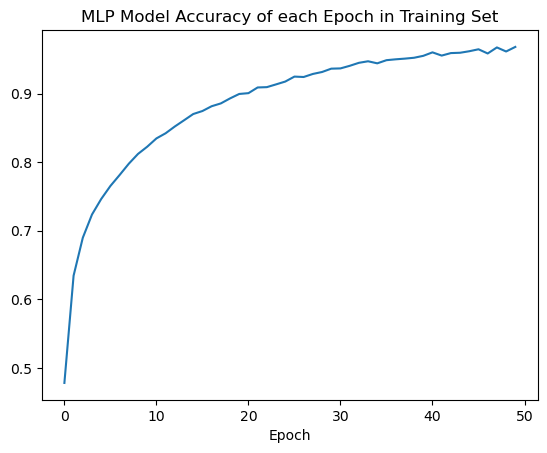

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.xlabel("Epoch")
plt.title('MLP Model Accuracy of each Epoch in Training Set')

### Convolutional neural network

In [34]:
np.random.seed(5318)
cnn = cnn_model(optimizer='rmsprop')


# Fit the model on the entire training dataset
cnn_history = cnn.fit(X_train, y_train, epochs=50, batch_size=200, validation_data=(X_val_reshaped, y_val))

# Predict the test set results
predictions = cnn.predict(X_test)

# Convert probabilistic outputs to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Evaluate the model on the test set if y_test is available
# Assuming y_test is available and is a class vector
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_classes)
print(f'Test Accuracy: {accuracy:2f}')



Epoch 1/50


/Users/ansonpoon/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3655 - loss: 1.8542 - val_accuracy: 0.6255 - val_loss: 1.1290
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6564 - loss: 1.0642 - val_accuracy: 0.7147 - val_loss: 0.8202
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7530 - loss: 0.7790 - val_accuracy: 0.7707 - val_loss: 0.6991
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8013 - loss: 0.6354 - val_accuracy: 0.8341 - val_loss: 0.5144
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8293 - loss: 0.5370 - val_accuracy: 0.8579 - val_loss: 0.4481
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8493 - loss: 0.4690 - val_accuracy: 0.8605 - val_loss: 0.4216
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8642 - loss: 0.4219 - val_accuracy: 0.8843 - val_loss: 0.3543
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8818 - loss: 0.3722 - val_accuracy: 0.8970 - val_loss: 0.

Text(0.5, 1.0, 'CNN Model Accuracy of each Epoch in Training Set')

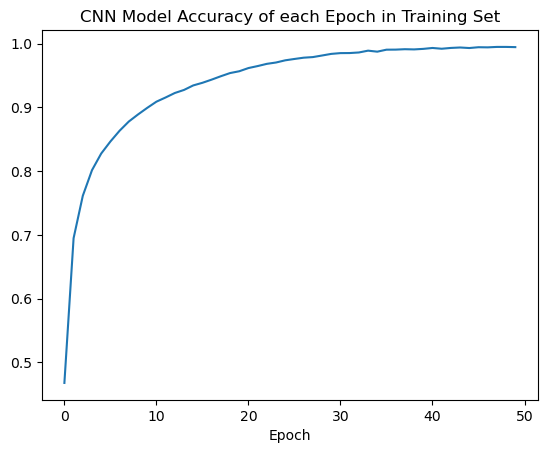

In [23]:
plt.plot(cnn_history.history['accuracy'])
plt.xlabel("Epoch")
plt.title('CNN Model Accuracy of each Epoch in Training Set')


#### recall, precision and confusion matrix

In [24]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix


In [25]:
### F1 score
from sklearn.metrics import f1_score
f1_cnn = f1_score(y_test, predicted_classes, average='macro') #cnn
f1_rf = f1_score(y_test, predictions4, average='macro') #random forest
f1_mlp = f1_score(y_test, predicted_classes_mlp, average='macro') # mlp

In [26]:
### Precision
f1_cnn = precision_score(y_test, predicted_classes, average='macro') #cnn
f1_rf = precision_score(y_test, predictions4, average='macro') #random forest
f1_mlp = precision_score(y_test, predicted_classes_mlp, average='macro') # mlp

In [29]:
print('CNN confusion matrix:',confusion_matrix(y_test, predicted_classes)) #cnn
print('Random Forest Confusion Matrix:',confusion_matrix(y_test, predictions4)) # random forest
print('MLP confusion matrix:',confusion_matrix(y_test, predicted_classes_mlp)) # mlp

CNN confusion matrix: [[ 383    4   16    1    7   15    3    0    0    4    3]
 [   5  206   16    1    1    1    0    0    0    3    1]
 [   0   12  211    0    2    2    1    0    0    0    1]
 [   0    0    0  241    0    0    1    1    0    2    0]
 [   2    1    2    1  326   33    2    0    0    6   17]
 [   6    0    5    0   23  356    9    1    0    4    9]
 [   0    0    4    0    0    4 1040    0    0    2    0]
 [   0    0    1    2    1    0    0  376    0    0    0]
 [   0    0    0    0    1    1    2    3  379    0    0]
 [   0    2    1    0    3    4    3    0    0  404    3]
 [   0    1    4    1    7    2    4    1    0    8  521]]
Random Forest Confusion Matrix: [[ 380    3    4    1    5   12    8    2    1   16    4]
 [   9  177    9    0    3   12    0    0    0   22    2]
 [  15    6  187    0    2    2    1    0    0   16    0]
 [   0    0    0  236    0    0    0    1    1    0    7]
 [  15    2    2    2  270   26    6    1    3   42   21]
 [  24    0    1 

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

# For CNN
cnn_precision = precision_score(y_test, predicted_classes, average='weighted')
cnn_recall = recall_score(y_test, predicted_classes, average='weighted')
cnn_f1_score = f1_score(y_test, predicted_classes, average='weighted')

# For Random Forest
rf_precision = precision_score(y_test, predictions4, average='weighted')
rf_recall = recall_score(y_test, predictions4, average='weighted')
rf_f1_score = f1_score(y_test, predictions4, average='weighted')

# For MLP
mlp_precision = precision_score(y_test, predicted_classes_mlp, average='weighted')
mlp_recall = recall_score(y_test, predicted_classes_mlp, average='weighted')
mlp_f1_score = f1_score(y_test, predicted_classes_mlp, average='weighted')

print("CNN Precision:", cnn_precision)
print("CNN Recall:", cnn_recall)
print("CNN F1 Score:", cnn_f1_score)

print("Random Forest Precision:", rf_precision)
print("Random Forest Recall:", rf_recall)
print("Random Forest F1 Score:", rf_f1_score)

print("MLP Precision:", mlp_precision)
print("MLP Recall:", mlp_recall)
print("MLP F1 Score:", mlp_f1_score)


CNN Precision: 0.9397566785628744
CNN Recall: 0.9389264581572274
CNN F1 Score: 0.9388744730495323
Random Forest Precision: 0.8943440481918794
Random Forest Recall: 0.8922231614539307
Random Forest F1 Score: 0.8913122488029813
MLP Precision: 0.877769356522446
MLP Recall: 0.86770921386306
MLP F1 Score: 0.8660449824470903


Text(0.5, 1.0, 'Accuracy of each plot in Training Set')

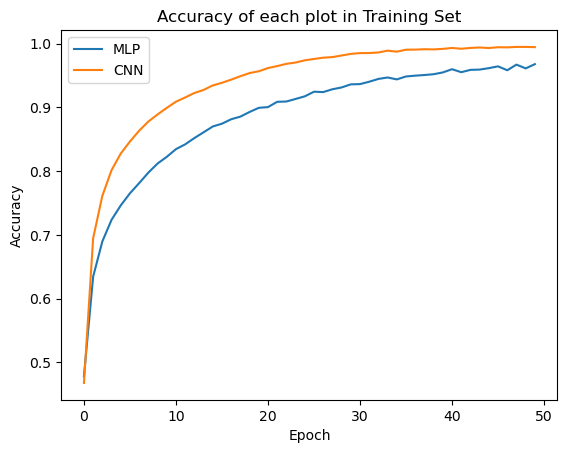

In [28]:
mlp_epoch=history.history['accuracy']
cnn_epoch=cnn_history.history['accuracy']
plt.plot(mlp_epoch, label = 'MLP')
plt.plot(cnn_epoch, label = 'CNN')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy of each plot in Training Set')

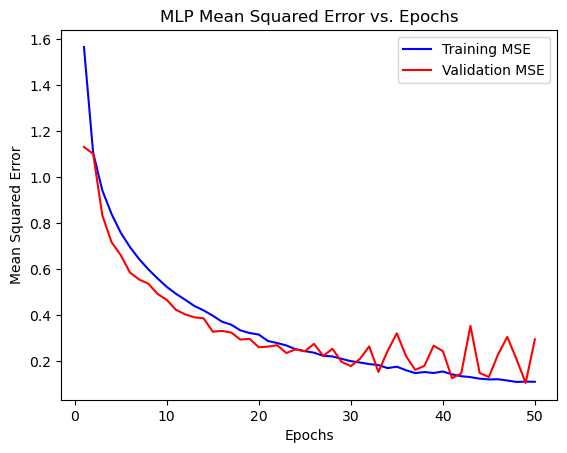

In [36]:
# Extract loss values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot mean squared error against epochs
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training MSE')
plt.plot(epochs, val_loss, 'r', label='Validation MSE')
plt.title('MLP Mean Squared Error vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()